The following code are the various models that we will be testing

In [ ]:
# like in the previous assignments, write a few model classes. maybe one FC and one CNN to start, maybe even an autoencoder style thing
# Each NN should return the style loss at various layers, and the content loss at various layers, as well as the final image

In [ ]:
# Here, do one forward pass of each of the NNs to test them

This is the resnet from the assignment with some changes
- no fully connected layers
- using padding on 1, stride 1, kernel size 3
- 3 channels all the way
- input and output dimensions need to be the same

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms

torch.cuda.is_available()

False

In [6]:
batch_size = 100 # complete
################## Need dataset###########################
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)


NameError: name 'train_subset' is not defined

In [4]:
class myResNet_withBN(nn.Module):
    def __init__(self):
        super(myResNet_withBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        self.BN1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding = 1)
        self.BN3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

        self.pool4 = nn.MaxPool2d(kernel_size = 3, stride = 1)

        self.conv5 =  nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        self.BN5 = nn.BatchNorm2d(3)
        self.relu5 = nn.ReLU()

        self.pool6 =nn.MaxPool2d(kernel_size = 3, stride = 1)

        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        # input to the residual unit
        h_in = self.relu1(self.BN1(self.conv1(x)))
        h = self.conv2(h_in)
        h = self.BN2(h)
        h = self.relu2(h)
        h = self.conv3(h) + h_in
        h = self.BN3(h)
        h = self.relu3(h)
        h = self.pool4(h)
        h = self.conv5(h)
        h = self.BN5(h)
        h = self.relu5(h)
        h = self.pool6(h)

        # Here, h is still kind of in image format
        # To make it appropriate for an FC layer, I flattened it
        #h = torch.reshape(h, (h.shape[0], -1))

        y = self.sigmoid8(h)
        return y

In [5]:
def train(model, num_epochs, device):
    # we first move our model to the configured device
    model = model.to(device = device)

    # set loss to binary CE
    loss_function = nn.BCELoss()

    # Set optimizer with optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    # Initiate the values
    train_risk = []

    for epoch in range(num_epochs):
        # training risk in one epoch
        risk = 0

        # loop over training data
        for i, (images, labels) in enumerate(train_loader):

            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            labels = torch.reshape(labels, (-1,1))
            labels = labels.float()

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model.forward(images)


            loss = loss_function(outputs, labels)

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()
            # complete: compute the gradient of loss
            # use auto-grad (just 1 line)
            loss.backward()

            # one step of gradient descent
            optimizer.step()

        # test out model after update by the optimizer
        #risk_epoch, accuracy_epoch = test(model, loss_function, device)

        # collect losses and accuracy
        train_risk.append(risk/i)

        # we can print a message every second epoch
        '''
        if (epoch+1) % 2 == 0:
            # complete: write your message
            print('test risk ', torch.round(torch.tensor(1-risk_epoch), decimals=2), '  test accuracy ', torch.round(torch.tensor(accuracy_epoch*100), decimals=2))
        '''


    # plot the losses
    plt.plot([i+1 for i in range(num_epochs)], train_risk)
    plt.show()


    return train_risk, train_risk

The following code is from a style transfer tutorial found on the pytorch docs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/images/picasso.jpg")
content_img = image_loader("/content/images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

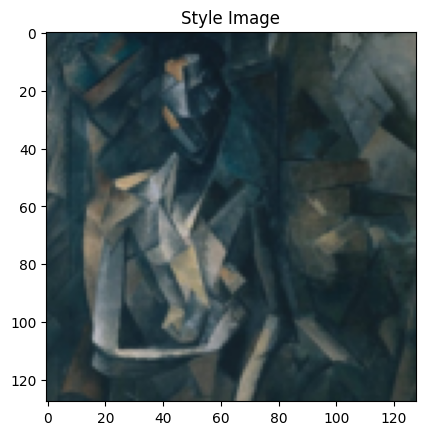

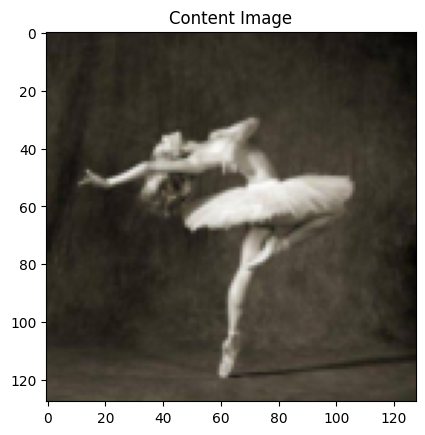

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.6MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

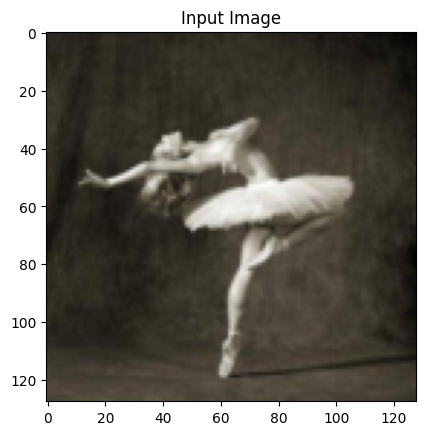

In [ ]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 26.476486 Content Loss: 9.871113

run [100]:
Style Loss : 7.033300 Content Loss: 8.725686

run [150]:
Style Loss : 3.777328 Content Loss: 8.008000

run [200]:
Style Loss : 2.695870 Content Loss: 7.461153

run [250]:
Style Loss : 2.212383 Content Loss: 7.119155

run [300]:
Style Loss : 1.952365 Content Loss: 6.905590



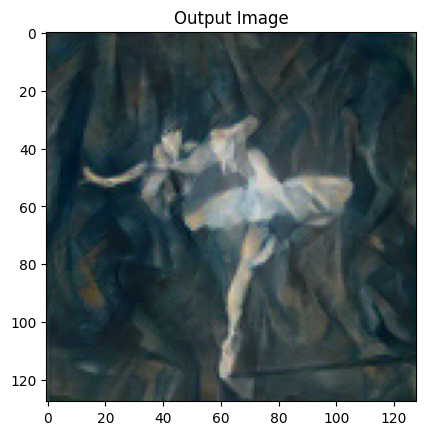

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()